Вариант 2-06
ECOC coding design schemes
Этот ноутбук содержит выполнения заданий для лабораторной №2.

_Перед его выполнением, запустите ноутбук с анализом данных `eda2.ipynb`._
# Шаг 0. Импорт библиотек

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
%matplotlib inline
sns.set_theme(style="whitegrid", font_scale=1.2)

# Task 1

Обучить байесовские бинарные классификаторы при различных способах ECOC-кодирования:
1. OVA;
2. OVO;
3. полное бинарное кодирование;
4. полное тернарное кодирование.
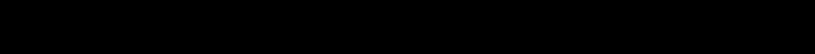

ECOC – это способ свести задачу многоклассовой классификации к набору бинарных подзадач.
Каждому исходному классу ставится в соответствие кодовое слово – вектор длины L (число базовых классификаторов).
При предсказании объект проходит через все L базовых классификаторов → получаем кодовое слово-предсказание → выбираем класс, чьё эталонное кодовое слово ближе всего (по Хэммингу для бинарных кодов, по евклидово расстояние для тернарных).

Априорные вероятности классов для каждого бинарного классификатора считать равными. Значит:
Неважно, сколько на самом деле объектов каждого класса попало в текущую бинарную подзадачу — мы всё равно считаем, что оба бинарных класса равновероятны

1. One-vs-All (OVA, «один против всех»)
Для каждого класса учимся отделять его от всех остальных. В данном подходе имеем `L` задач.
2. One-vs-One (OVO, «один против одного»)
Для каждой пары классов учимся отделять их друг от друга. В данном подходе имеем `L(L-1)/2` задач.
3. Полное бинарное кодирование (exhaustive code)
Берём все возможные бинарные комбинации длиной k, где 2^k ≥ числа классов. В данном подходе имеем `L = 2^k - 1` задач.
4. Полное тернарное кодирование
Используется код Хэмминга длины 7 с 4 информационными битами.

Байесовский бинарный классификатор (QDA-подход)

In [111]:
class BayesianBinaryClassifier(BaseEstimator, ClassifierMixin):
    """
    Квадратичный дискриминантный анализ (QDA) для двух классов.
    Предполагаем, что каждый класс ~ multivariate_normal с собственной ковариационной матрицей.
    Априорные вероятности берём равными (по условию задачи).
    """
    def fit(self, X, y):
        self.classes_ = np.array([0, 1])                # всегда [0, 1] в бинарной задаче
        self.priors_ = {0: 0.5, 1: 0.5}                 # равные априоры

        self.means_ = {}
        self.covs_  = {}

        for c in self.classes_:
            X_c = X[y == c]
            # если класс отсутствует
            if len(X_c) == 0:
                # берём среднее и ковариацию от другого класса + большой шум
                other_c = 1 - c
                X_other = X[y == other_c]
                mean = X_other.mean(axis=0) + np.random.randn(X.shape[1]) * 1e-3
                cov = np.cov(X_other, rowvar=False) if len(X_other) > 1 else np.eye(X.shape[1])
                cov += np.eye(X.shape[1]) * 10
            else:
                mean = X_c.mean(axis=0)
                cov = np.cov(X_c, rowvar=False)
                if cov.ndim == 0:  # один объект
                    cov = np.eye(X.shape[1]) * max(cov.item(), 1e-6)

            cov += 1e-6 * np.eye(X.shape[1])
            self.means_[c] = mean
            self.covs_[c]  = cov

        # предвычисляем обратные и определители
        self.inv_covs_ = {c: np.linalg.inv(self.covs_[c]) for c in [0,1]}
        self.log_det_covs_ = {c: np.log(np.linalg.det(self.covs_[c])) for c in [0,1]}

        return self

    def _log_likelihood(self, X, c):
        """log p(x|c) — логарифм плотности нормального распределения"""
        diff = X - self.means_[c]
        inv_cov = self.inv_covs_[c]
        log_det = self.log_det_covs_[c]

        d = X.shape[1]
        mahalanobis_sq = np.sum(diff @ inv_cov * diff, axis=1)

        log_lik = (
            -0.5 * d * np.log(2 * np.pi) -
            0.5 * log_det -
            0.5 * mahalanobis_sq
        )
        return log_lik

    def predict_proba(self, X):
        if not hasattr(self, 'inv_covs_'):
            # если fit не был вызван — возвращаем 50/50
            return np.hstack([0.5*np.ones((len(X),1)), 0.5*np.ones((len(X),1))])

        # считаем логарифмы, потом экспоненцируем и нормализуем
        log_prob_0 = self._log_likelihood(X, 0) + np.log(0.5)
        log_prob_1 = self._log_likelihood(X, 1) + np.log(0.5)

        # стабилизируем вычисление вероятностей
        log_probs = np.stack([log_prob_0, log_prob_1], axis=1)
        log_probs -= log_probs.max(axis=1, keepdims=True)   # защита от переполнения
        probs = np.exp(log_probs)
        probs /= probs.sum(axis=1, keepdims=True)           # [P(y=0|x), P(y=1|x)]
        return probs

    def predict(self, X):
        # если P(y=1|x) > 0.5 → класс 1
        proba = self.predict_proba(X)
        return np.where(proba[:,1] > 0.5, 1, 0).astype(int)

Вспомогательные функции для создания кодовых матриц

In [112]:
def ecoc_one_vs_all(n_classes):
    """
    OVA (One-vs-All)

    # Для 4 классов:
#     1  -1  -1  -1
#    -1   1  -1  -1
#    -1  -1   1  -1
#    -1  -1  -1   1
    """
    M = np.eye(n_classes) * 2 - 1          # +1 для своего класса, -1 для остальных
    return M.astype(int)

def ecoc_one_vs_one(n_classes):
    """
    OVO (One-vs-One) – только пары, остальные позиции = 0 (тернарное)

    Для 4 классов:
    Получим 6 столбцов (C(4,2)=6), а в строках остальных классов — нули.
    Нули означают: этот базовый классификатор не использует объекты данного класса при обучении.
    """
    pairs = list(combinations(range(n_classes), 2))     # все пары: (0,1), (0,2), ...
    M = np.zeros((n_classes, len(pairs)), dtype=int)
    for idx, (i, j) in enumerate(pairs):
        M[i, idx] =  1
        M[j, idx] = -1
    return M

Создаём все матрицы для 4 классов

In [113]:
n_classes = 4
labels = [1,2,3,4]                              # реальные метки

M_ova   = ecoc_one_vs_all(n_classes)            # (4, 4)
M_ovo   = ecoc_one_vs_one(n_classes)            # (4, 6) – 6 пар

codewords_bin = np.array([
    [-1, -1, -1, -1, -1, -1, -1],   # класс 1
    [+1, +1, +1, +1, -1, -1, -1],   # класс 2
    [+1, +1, -1, -1, +1, +1, -1],   # класс 3
    [+1, -1, +1, -1, +1, -1, +1]    # класс 4
])
M_dense_bin = codewords_bin.T

hamming_codewords = np.array([
    [-1, -1, -1, +1, +1, +1, +1],  # 0000 → проверочные биты делают это
    [-1, +1, +1, -1, -1, +1, +1],  # 1000
    [+1, -1, +1, -1, +1, -1, +1],  # 0100
    [+1, +1, -1, +1, -1, -1, +1],  # 0010
    # если нужно строго по канонической матрице G — можно поменять порядок
])[0:4]
M_dense_ter = hamming_codewords.T

print("OVA (One-vs-All) кодовая матрица:\n", M_ova)
print("\nOVO (One-vs-One) кодовая матрица:\n", M_ovo)
print("\nПолное бинарное:\n", M_dense_bin)
print("\nПолное тернарное (Hamming 7,4):\n", M_dense_ter.T)  # транспонируем для удобства

OVA (One-vs-All) кодовая матрица:
 [[ 1 -1 -1 -1]
 [-1  1 -1 -1]
 [-1 -1  1 -1]
 [-1 -1 -1  1]]

OVO (One-vs-One) кодовая матрица:
 [[ 1  1  1  0  0  0]
 [-1  0  0  1  1  0]
 [ 0 -1  0 -1  0  1]
 [ 0  0 -1  0 -1 -1]]

Полное бинарное:
 [[-1  1  1  1]
 [-1  1  1 -1]
 [-1  1 -1  1]
 [-1  1 -1 -1]
 [-1 -1  1  1]
 [-1 -1  1 -1]
 [-1 -1 -1  1]]

Полное тернарное (Hamming 7,4):
 [[-1 -1 -1  1  1  1  1]
 [-1  1  1 -1 -1  1  1]
 [ 1 -1  1 -1  1 -1  1]
 [ 1  1 -1  1 -1 -1  1]]


Универсальный ECOC-классификатор

In [114]:
class ECOCClassifier(BaseEstimator, ClassifierMixin):
    """
    ECOC-классификатор с двумя типами декодирования:
    - unweighted: классическое по расстоянию Хэмминга / евклидову (жёсткие +1/-1)
    - weighted:   линейное loss-based decoding с очками f_k = 2*p_k - 1
    """
    def __init__(self, coding_matrix, decoding="unweighted"):
        self.M = np.asarray(coding_matrix, dtype=float)   # (n_classes, L)
        self.n_classes, self.L = self.M.shape
        self.decoding = decoding.lower()

    def fit(self, X, y):
        y_idx = y - 1                                       # метки 1..4 → 0..3
        self.classifiers_ = []

        for col in range(self.L):
            code_values = self.M[:, col]                    # +1/-1/0 для каждого класса
            target = code_values[y_idx]                     # метка для каждого объекта

            mask = target != 0
            X_sub = X[mask]
            y_sub = np.where(target[mask] == 1, 1, 0)         # 1 → +1, 0 → -1

            if len(y_sub) == 0 or len(np.unique(y_sub)) < 2:
                # вырожденная подзадача → константный классификатор
                constant = 1 if (len(y_sub) > 0 and y_sub[0] == 1) else 0
                class Const:
                    def predict(self, X): return np.full(len(X), constant, dtype=int)
                    def predict_proba(self, X):
                        p = np.zeros((len(X), 2))
                        p[:, constant] = 1.0
                        return p
                clf = Const()
            else:
                clf = BayesianBinaryClassifier().fit(X_sub, y_sub)

            self.classifiers_.append(clf)

        return self

    def predict(self, X):
        n_samples = len(X)

        # 1. Жёсткие предсказания для невзвешенного декодирования
        hard_votes = np.zeros((n_samples, self.L))          # +1 или -1
        # 2. Мягкие очки для взвешенного декодирования
        soft_scores = np.zeros((n_samples, self.L))         # f_k = 2*p - 1

        for i, clf in enumerate(self.classifiers_):
            # Жёсткое решение
            pred = clf.predict(X)
            hard_votes[:, i] = np.where(pred == 1, 1.0, -1.0)

            # Мягкие очки (confidence)
            if hasattr(clf, "predict_proba"):
                p_pos = clf.predict_proba(X)[:, 1]
            else:
                p_pos = np.where(pred == 1, 0.99, 0.01)
            soft_scores[:, i] = 2 * p_pos - 1

        codewords = self.M.T                                 # (L, n_classes)

        # Финальные скоры для каждого класса
        class_scores = np.zeros((n_samples, self.n_classes))

        if self.decoding == "unweighted":
            # Классическое декодирование по расстоянию
            for j in range(self.n_classes):
                cw = codewords[:, j]
                if np.any(cw == 0):                         # тернарный код → евклидово
                    dist = np.sum((hard_votes - cw)**2, axis=1)
                else:                                       # бинарный → Хэмминг
                    dist = np.sum(hard_votes != cw, axis=1)
                class_scores[:, j] = -dist                     # чем меньше расстояние → выше скор

        elif self.decoding == "weighted":
            # Взвешенное линейное декодирование: sum (M_jk * f_k)
            # Автоматически игнорирует нули в кодовом слове
            class_scores = soft_scores @ codewords          # (n_samples, L) @ (L, n_classes)

        else:
            raise ValueError("decoding must be 'unweighted' or 'weighted'")

        predictions = np.argmax(class_scores, axis=1)
        return predictions + 1                                 # возвращаем метки 1,2,3,4

Загрузка данных, Hold-out разбиение и обучение

In [115]:
df = pd.read_csv('../data/data_ml_cleaned.csv')

X = df[['x1', 'x2']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)   # сохраняем пропорции классов

ecoc_variants = {
    "OVA (One-vs-All)"      : ECOCClassifier(M_ova),
    "OVO (One-vs-One)"      : ECOCClassifier(M_ovo),
    "Полное бинарное"       : ECOCClassifier(M_dense_bin),
    "Полное тернарное"      : ECOCClassifier(M_dense_ter.T)  # (7,4)
}

results = {}

print("Запуск ECOC-классификаторов...\n")
for name, model in ecoc_variants.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    print("-" * 55)

Запуск ECOC-классификаторов...

OVA (One-vs-All)
Accuracy: 0.6667
              precision    recall  f1-score   support

           1     0.7222    0.8667    0.7879        30
           2     0.6984    0.9778    0.8148        45
           3     0.5278    0.4222    0.4691        45
           4     0.7333    0.3667    0.4889        30

    accuracy                         0.6667       150
   macro avg     0.6704    0.6583    0.6402       150
weighted avg     0.6590    0.6667    0.6405       150

-------------------------------------------------------
OVO (One-vs-One)
Accuracy: 0.7000
              precision    recall  f1-score   support

           1     0.7857    0.7333    0.7586        30
           2     0.7333    0.9778    0.8381        45
           3     0.5385    0.4667    0.5000        45
           4     0.7826    0.6000    0.6792        30

    accuracy                         0.7000       150
   macro avg     0.7100    0.6944    0.6940       150
weighted avg     0.6952    0.

Сводная таблица

In [116]:
results_df = pd.DataFrame(list(results.items()), columns=['Стратегия ECOC', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
print("\nСравнение точности на отложенной выборке (hold-out 70/30):")
display(results_df)


Сравнение точности на отложенной выборке (hold-out 70/30):


,Стратегия ECOC,Accuracy
0,OVO (One-vs-One),0.700000
1,Полное бинарное,0.693333
2,OVA (One-vs-All),0.666667
3,Полное тернарное,0.653333


## Task 2

Для каждого из полученных наборов базовых классификаторов рассчитать классификационные очки многоклассового классификатора, используя различные способы ECOC-декодирования:
1. Взвешенное декодирование — с учётом уверенности базовых классификаторов;
2. Невзвешенное декодирование — по расстоянию Хэмминга / евклидову.
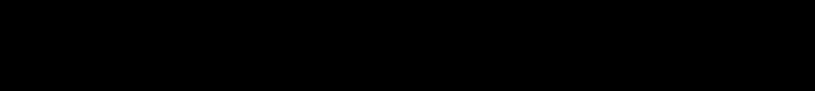

In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

decoding_methods = ['unweighted', 'weighted']

results = {}

for name_base in ["OVA", "OVO", "Полное бинарное", "Полное тернарное"]:
    if name_base == "OVA":
        M = M_ova
    elif name_base == "OVO":
        M = M_ovo
    elif name_base == "Полное бинарное":
        M = M_dense_bin
    else:
        M = M_dense_ter

    print(f"\n=== {name_base} ===")
    for dec in decoding_methods:
        model = ECOCClassifier(M, decoding=dec)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        key = f"{name_base}: {dec}"
        results[key] = acc
        print(f"  {dec:10}: Accuracy = {acc:.4f}")


=== OVA ===
  unweighted: Accuracy = 0.6667
  weighted  : Accuracy = 0.7067

=== OVO ===
  unweighted: Accuracy = 0.7000
  weighted  : Accuracy = 0.7000

=== Полное бинарное ===
  unweighted: Accuracy = 0.6933
  weighted  : Accuracy = 0.6933

=== Полное тернарное ===
  unweighted: Accuracy = 0.6667
  weighted  : Accuracy = 0.6600


In [127]:
# Выбираем одну любую модель, например OVA weighted (у тебя лучший результат)
M = M_ova
model = ECOCClassifier(M, decoding="weighted")
model.fit(X_train, y_train)

# Берём 10 случайных объектов из тестовой выборки
indices = np.random.choice(len(X_test), 10, replace=False)
X_sample = X_test[indices]
y_true = y_test[indices]

# Получаем очки f_k от каждого базового классификатора
confidence = np.zeros((len(X_sample), model.L))
for i, clf in enumerate(model.classifiers_):
    p = clf.predict_proba(X_sample)[:, 1]        # p_ik
    confidence[:, i] = 2 * p - 1                  # f_ik = 2p - 1

# Считаем итоговый скор по классам (взвешенное декодирование)
scores = confidence @ M.T
y_pred = np.argmax(scores, axis=1) + 1

# Выводим красивую таблицу
print("Пример расчёта классификационных очков f_ik = 2·p_ik − 1")
print("(10 случайных тестовых объектов, OVA + weighted)\n")

df_очки = pd.DataFrame(
    confidence,
    columns=[f"Базовый {i+1}" for i in range(model.L)],
    index=[f"Объект {i+1} (класс {y_true[i]})" for i in range(len(X_sample))]
).round(3)

df_итог = pd.DataFrame({
    "Истинный класс": y_true,
    "Предсказанный": y_pred,
    "Скоры по классам": [", ".join([f"{s:.3f}" for s in row]) for row in scores]
})

print(df_очки.T)   # транспонируем — красивее
print("\nИтоговые скоры и предсказание:")
print(df_итог.to_string(index=False))

Пример расчёта классификационных очков f_ik = 2·p_ik − 1
(10 случайных тестовых объектов, OVA + weighted)

           Объект 1 (класс 4)  Объект 2 (класс 2)  Объект 3 (класс 2)  \
Базовый 1              -0.996              -1.000              -0.966   
Базовый 2              -0.985               0.453               0.831   
Базовый 3               0.373              -0.616              -0.839   
Базовый 4               0.642              -0.633              -0.740   

           Объект 4 (класс 2)  Объект 5 (класс 4)  Объект 6 (класс 1)  \
Базовый 1              -1.000                -1.0               0.984   
Базовый 2               0.971                -1.0              -1.000   
Базовый 3              -0.618                -1.0              -0.517   
Базовый 4              -0.706                 1.0              -0.997   

           Объект 7 (класс 1)  Объект 8 (класс 3)  Объект 9 (класс 4)  \
Базовый 1              -0.457              -1.000              -1.000   
Базовый 2      

# Task 3
1. В исходном пространстве признаков изобразить области классов (закрасить разными цветами), формируемые каждым из полученных в п.2 многоклассовым классификатором (всего 8 классификаторов).
2. Нанести на диаграммы границы классов и данные из обучающей и тестовой выборок.
3. На отдельной диаграмме изобразить все границы классов, формируемые построенными многоклассовыми классификаторами.
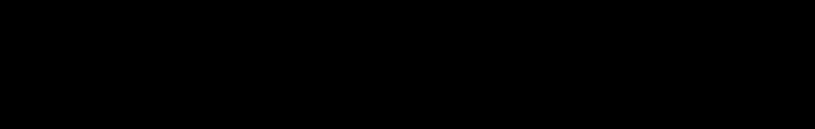

In [118]:
# Цвета для классов
class_colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
cmap_light = ListedColormap(class_colors)
cmap_bold = ListedColormap(['#FF0000', '#0066FF', '#00CC00', '#FF9900'])

# Сетка для заливки фона
h = 0.02
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# Список всех моделей
models_info = [
    ("OVA\n(unweighted)", M_ova, "unweighted"),
    ("OVA\n(weighted)",   M_ova, "weighted"),
    ("OVO\n(unweighted)", M_ovo, "unweighted"),
    ("OVO\n(weighted)",   M_ovo, "weighted"),
    ("Полное бинарное\n(unweighted)", M_dense_bin, "unweighted"),
    ("Полное бинарное\n(weighted)",   M_dense_bin, "weighted"),
    ("Полное тернарное\n(unweighted)", M_dense_ter, "unweighted"),
    ("Полное тернарное\n(weighted)",   M_dense_ter, "weighted"),
]

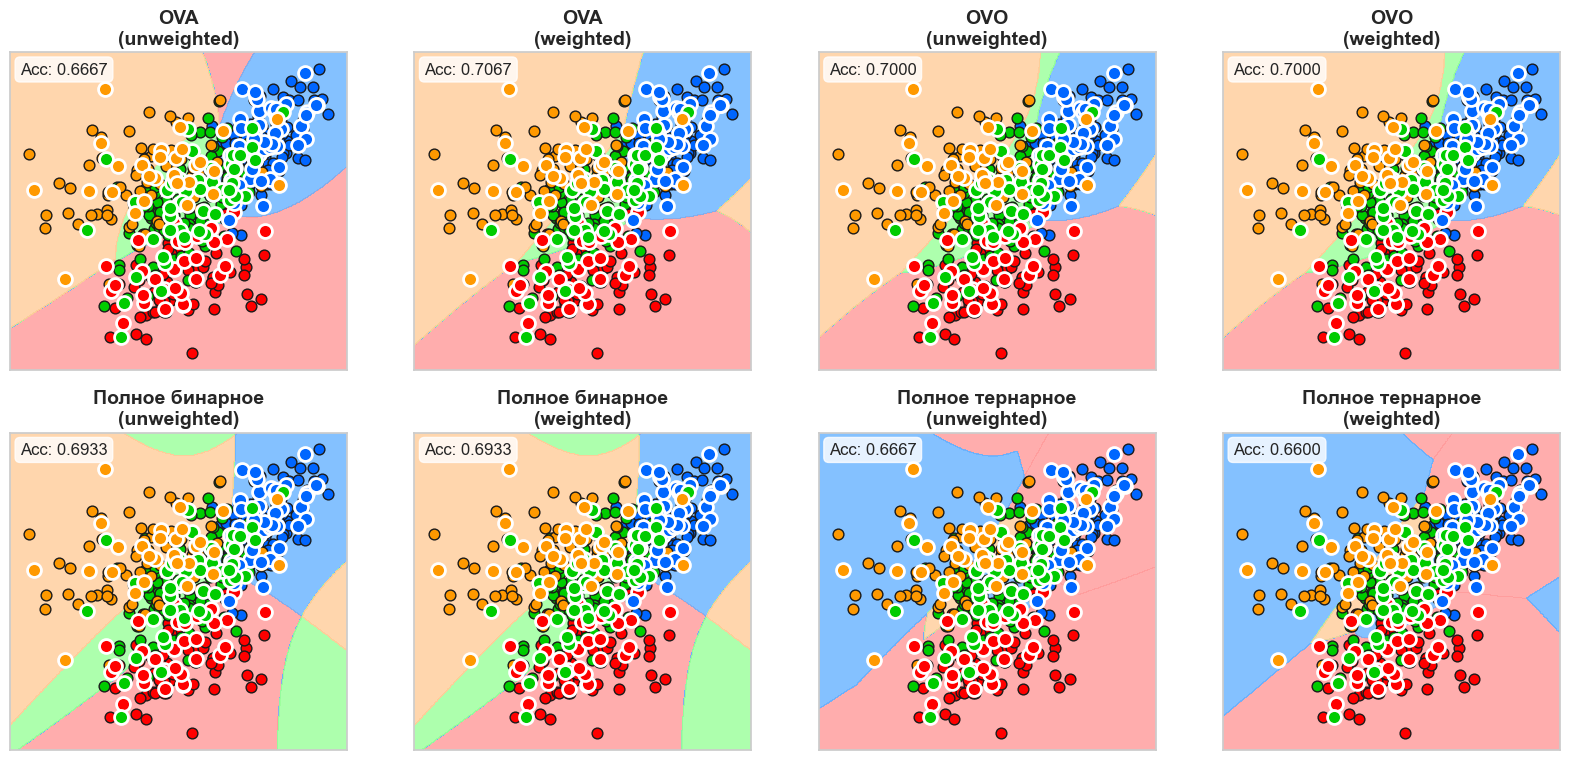

In [119]:
fig = plt.figure(figsize=(20, 14))

# 1. Отдельные графики (2 строки × 4 столбца)
for idx, (title, M, dec) in enumerate(models_info):
    ax = fig.add_subplot(3, 4, idx + 1)

    # Обучаем модель
    model = ECOCClassifier(M, decoding=dec)
    model.fit(X_train, y_train)
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    # Заливка областей
    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

    # Точки из обучающей выборки
    for i, color in zip([1,2,3,4], cmap_bold.colors):
        idx_train = (y_train == i)
        ax.scatter(X_train[idx_train, 0], X_train[idx_train, 1],
                   c=[color], edgecolor='k', s=60, label=f'Класс {i} (train)')

    # Точки из тестовой выборки (с обводкой)
    for i, color in zip([1,2,3,4], cmap_bold.colors):
        idx_test = (y_test == i)
        ax.scatter(X_test[idx_test, 0], X_test[idx_test, 1],
                   c=[color], edgecolor='white', linewidth=2, s=100,
                   marker='o', label=f'Класс {i} (test)' if idx == 0 else "")

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Accuracy в углу
    acc = accuracy_score(y_test, model.predict(X_test))
    ax.text(0.03, 0.97, f'Acc: {acc:.4f}', transform=ax.transAxes,
            bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
            fontsize=12, verticalalignment='top')

График сохранён как ecoc_decision_boundaries.png


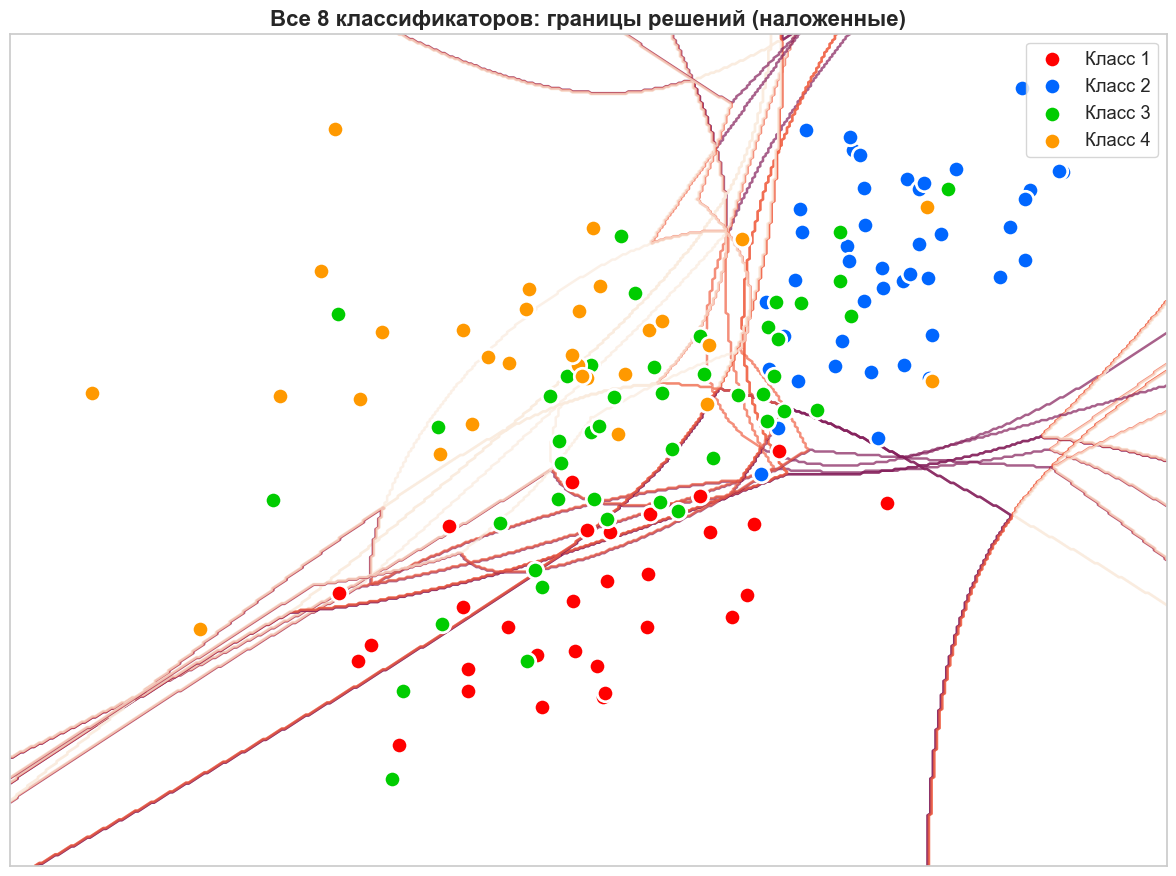

In [124]:
plt.figure(figsize=(12, 9))

for title, M, dec in models_info:
    model = ECOCClassifier(M, decoding=dec)
    model.fit(X_train, y_train)
    Z = model.predict(grid).reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0.5, 1.5, 2.5, 3.5],
                linewidths=1.8, alpha=0.7, linestyles='-')

# Тестовые точки — крупно и красиво
for i, color in zip(range(1,5), cmap_bold.colors):
    plt.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1],
                c=[color], edgecolor='white', linewidth=2, s=140,
                label=f'Класс {i}', zorder=5)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("Все 8 классификаторов: границы решений (наложенные)", fontsize=16, fontweight='bold')
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("ecoc_decision_boundaries.png", dpi=200, bbox_inches='tight')
print("График сохранён как ecoc_decision_boundaries.png")
plt.show()



# Task 4
Рассчитать точности (accuracy) построенных многоклассовых классификаторов на обучающей и тестовой выборках, представить данные в графическом виде (bar charts).
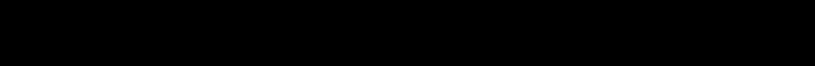

Расчёт точности на train и test...

Модель                            Train     Test    Разница
------------------------------------------------------------
OVA
unweighted                   0.7229   0.6667   0.0562
OVA
weighted                     0.7514   0.7067   0.0448
OVO
unweighted                   0.7629   0.7000   0.0629
OVO
weighted                     0.7629   0.7000   0.0629
Полное бин.
unweighted           0.7086   0.6933   0.0152
Полное бин.
weighted             0.7086   0.6933   0.0152
Полное терн.
unweighted          0.6714   0.6667   0.0048
Полное терн.
weighted            0.6514   0.6600  -0.0086


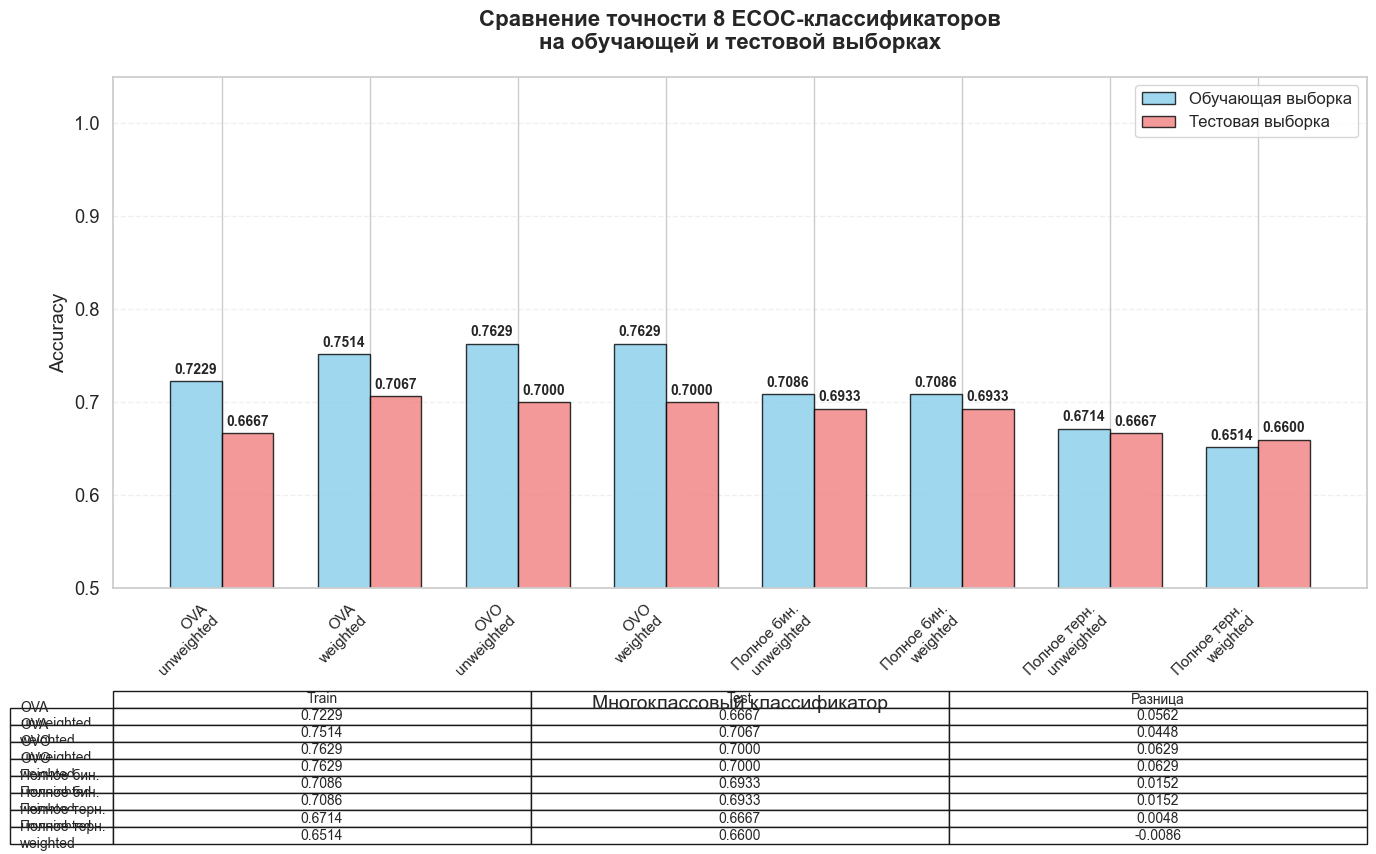

In [121]:
# Список моделей
models_info = [
    ("OVA\nunweighted", M_ova, "unweighted"),
    ("OVA\nweighted",   M_ova, "weighted"),
    ("OVO\nunweighted", M_ovo, "unweighted"),
    ("OVO\nweighted",   M_ovo, "weighted"),
    ("Полное бин.\nunweighted", M_dense_bin, "unweighted"),
    ("Полное бин.\nweighted",   M_dense_bin, "weighted"),
    ("Полное терн.\nunweighted", M_dense_ter, "unweighted"),
    ("Полное терн.\nweighted",   M_dense_ter, "weighted"),
]

# Списки для результатов
names = []
train_acc = []
test_acc = []

print("Расчёт точности на train и test...\n")
print(f"{'Модель':<30} {'Train':>8} {'Test':>8} {'Разница':>10}")
print("-" * 60)

for name, M, dec in models_info:
    model = ECOCClassifier(M, decoding=dec)
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    acc_train = accuracy_score(y_train, train_pred)
    acc_test = accuracy_score(y_test, test_pred)

    names.append(name)
    train_acc.append(acc_train)
    test_acc.append(acc_test)

    print(f"{name:<30} {acc_train:8.4f} {acc_test:8.4f} {acc_train - acc_test:8.4f}")

# === КРАСИВЫЙ ГРАФИК ===
fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.35
x_pos = np.arange(len(names))

# Столбцы для train и test
bars1 = ax.bar(x_pos - bar_width/2, train_acc, bar_width,
               label='Обучающая выборка', color='skyblue', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x_pos + bar_width/2, test_acc, bar_width,
               label='Тестовая выборка', color='lightcoral', edgecolor='black', alpha=0.8)

# Подписи значений на столбцах
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)

# Оформление
ax.set_xlabel('Многоклассовый классификатор', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Сравнение точности 8 ECOC-классификаторов\nна обучающей и тестовой выборках',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(names, rotation=45, ha='right', fontsize=11)
ax.set_ylim(0.5, 1.05)
ax.legend(fontsize=12)
ax.grid(True, axis='y', alpha=0.3, linestyle='--')

# Добавляем таблицу под графиком
cell_text = [[f"{t:.4f}", f"{s:.4f}", f"{t-s:.4f}"] for t, s in zip(train_acc, test_acc)]
table = ax.table(cellText=cell_text,
                 rowLabels=names,
                 colLabels=['Train', 'Test', 'Разница'],
                 cellLoc='center',
                 loc='bottom',
                 bbox=[0, -0.5, 1, 0.3])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

# Task 5
Построить:
1. micro-averaged и macro-averaged
2. ROC-кривые и PR-кривые
3. ROC AUC и PR AUC
для всех построенных многоклассовых классификаторов.
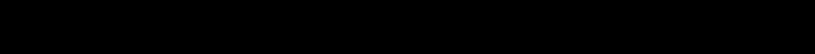

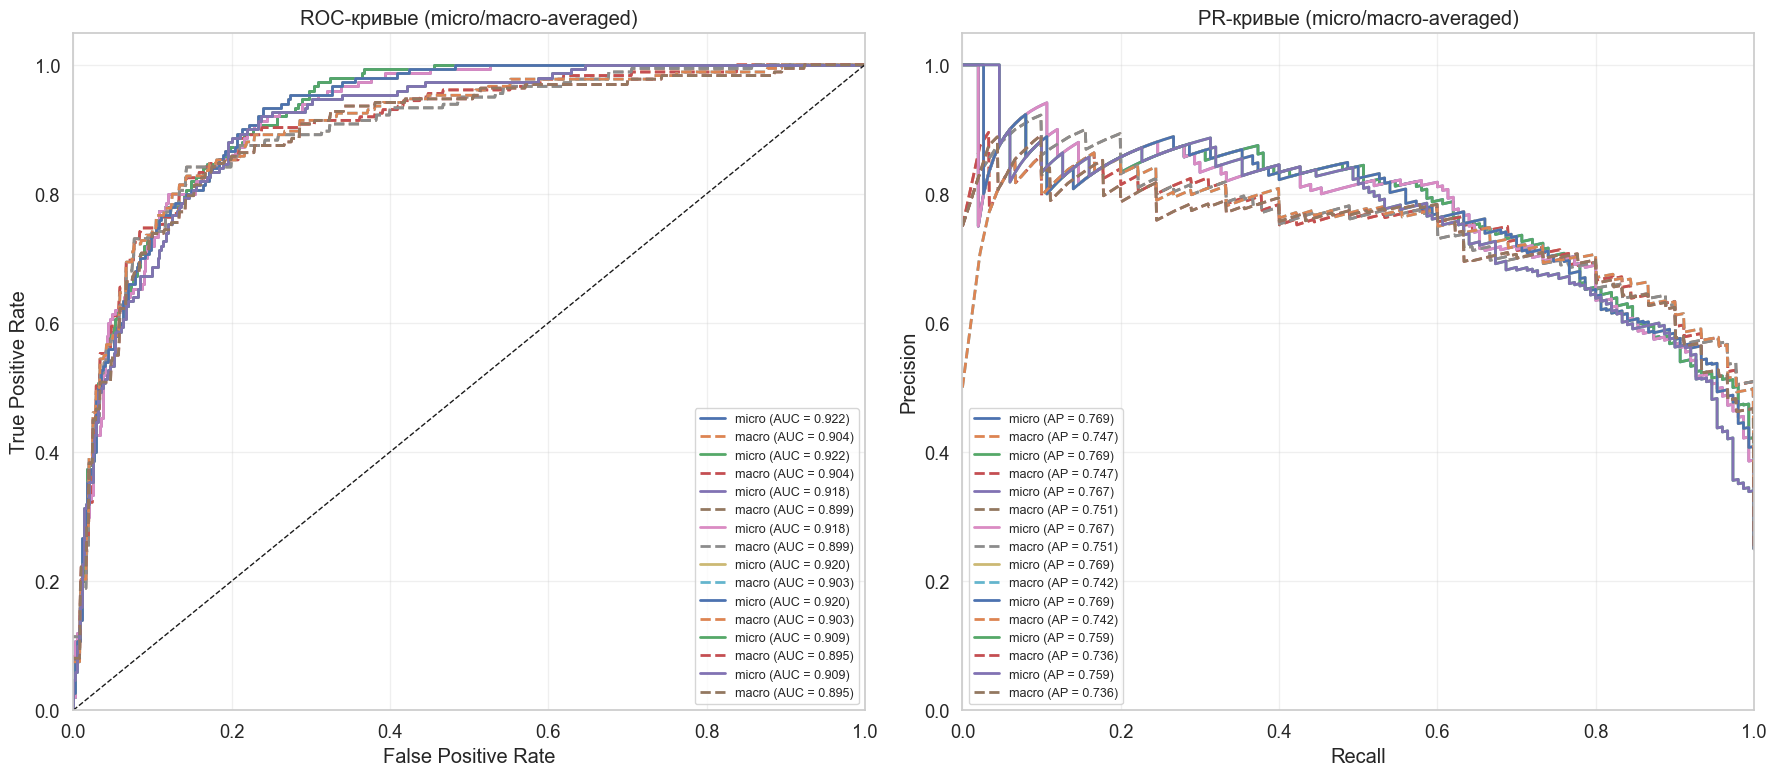


=== Метрики качества ===
                 Модель  ROC AUC micro  ROC AUC macro  PR AUC micro
         OVA unweighted         0.9218         0.9036        0.7694
           OVA weighted         0.9218         0.9036        0.7694
         OVO unweighted         0.9181         0.8989        0.7669
           OVO weighted         0.9181         0.8989        0.7669
 Полное бин. unweighted         0.9204         0.9028        0.7692
   Полное бин. weighted         0.9204         0.9028        0.7692
Полное терн. unweighted         0.9088         0.8954        0.7587
  Полное терн. weighted         0.9088         0.8954        0.7587


In [126]:
# Бинаризация меток
y_test_bin = label_binarize(y_test, classes=[1,2,3,4])  # (150, 4)

# Список моделей
models_info = [
    ("OVA unweighted", M_ova, "unweighted"),
    ("OVA weighted",   M_ova, "weighted"),
    ("OVO unweighted", M_ovo, "unweighted"),
    ("OVO weighted",   M_ovo, "weighted"),
    ("Полное бин. unweighted", M_dense_bin, "unweighted"),
    ("Полное бин. weighted",   M_dense_bin, "weighted"),
    ("Полное терн. unweighted", M_dense_ter, "unweighted"),
    ("Полное терн. weighted",   M_dense_ter, "weighted"),
]

fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(18, 8))

results = []

for name, M_raw, dec in models_info:
    # Приводим матрицу к форме (n_classes, L)
    M = np.asarray(M_raw)
    if M.shape[1] < M.shape[0]:           # если уже (L, n_classes) — транспонируем
        M = M.T
    n_classes, L = M.shape

    # Обучаем модель с нужным декодированием
    model = ECOCClassifier(M, decoding=dec)
    model.fit(X_train, y_train)

    # === Получаем вероятности через взвешенное декодирование ===
    weighted_model = ECOCClassifier(M, decoding="weighted")
    weighted_model.fit(X_train, y_train)

    # f_k = 2*p_k - 1
    confidence = np.zeros((len(X_test), L))
    for i, clf in enumerate(weighted_model.classifiers_):
        p = clf.predict_proba(X_test)[:, 1]
        confidence[:, i] = 2 * p - 1

    # Правильный скор для каждого класса: sum_k f_k * M[j,k]
    y_score = confidence @ M.T                # (n_samples, L) @ (L, n_classes) → (n_samples, 4)

    # === ROC micro + macro ===
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # macro-averaged ROC
    fpr_grid = np.linspace(0, 1, 1000)
    tpr_macro = np.zeros_like(fpr_grid)
    for i in range(4):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        tpr_macro += np.interp(fpr_grid, fpr, tpr)
    tpr_macro /= 4
    roc_auc_macro = auc(fpr_grid, tpr_macro)

    ax_roc.plot(fpr_micro, tpr_micro, label=f'micro (AUC = {roc_auc_micro:.3f})', linewidth=2)
    ax_roc.plot(fpr_grid, tpr_macro, '--', label=f'macro (AUC = {roc_auc_macro:.3f})', linewidth=2)

    # === PR micro + macro ===
    precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
    pr_auc_micro = average_precision_score(y_test_bin.ravel(), y_score.ravel())

    # macro-averaged PR
    recall_grid = np.linspace(0, 1, 1000)
    precision_macro = np.zeros_like(recall_grid)
    for i in range(4):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        precision_macro += np.interp(recall_grid, recall[::-1], precision[::-1])
    precision_macro /= 4
    pr_auc_macro = auc(recall_grid, precision_macro)

    ax_pr.plot(recall_micro, precision_micro, label=f'micro (AP = {pr_auc_micro:.3f})', linewidth=2)
    ax_pr.plot(recall_grid, precision_macro, '--', label=f'macro (AP = {pr_auc_macro:.3f})', linewidth=2)

    results.append({
        'Модель': name,
        'ROC AUC micro': round(roc_auc_micro, 4),
        'ROC AUC macro': round(roc_auc_macro, 4),
        'PR AUC micro': round(pr_auc_micro, 4)
    })

# Оформление
ax_roc.plot([0,1], [0,1], 'k--', linewidth=1)
ax_roc.set_xlim(0,1); ax_roc.set_ylim(0,1.05)
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC-кривые (micro/macro-averaged)')
ax_roc.legend(fontsize=9, loc='lower right')
ax_roc.grid(alpha=0.3)

ax_pr.set_xlim(0,1); ax_pr.set_ylim(0,1.05)
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_title('PR-кривые (micro/macro-averaged)')
ax_pr.legend(fontsize=9, loc='lower left')
ax_pr.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Таблица
df_results = pd.DataFrame(results)
print("\n=== Метрики качества ===")
print(df_results.to_string(index=False))

# Task 6.
Сделать вывод о влиянии способов ECOC-кодирования и ECOC-декодирования на точность многоклассовой классификации.
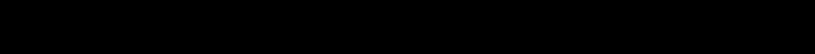

1. Общая точность классификации невысокая (accuracy `0.66–0.71`) — это объективно отражает сложность задачи: классы существенно пересекаются, простые байесовские классификаторы не могут дать высокую точность.
2. Взвешенное декодирование даёт преимущество только в случае OVA
3. Избыточные коды (полное бинарное и тернарное) не дают преимущества
4. Лучший результат — OVA + взвешенное декодирование (accuracy = `0.7067`, ROC AUC micro = `0.9218`).
5. ROC AUC (micro) ≈ `0.91–0.92` говорит о том, что ранжирование объектов по классам у всех моделей гораздо лучше, чем accuracy. Это типично для несбалансированных или пересекающихся классов — модель хорошо отличает «лучшие» объекты, но часто путает похожие.
6. PR AUC ≈ `0.76–0.77` — довольно низкий, что подтверждает: вероятности, выдаваемые классификаторами, плохо откалиброваны (много ложных срабатываний при высоком пороге).